In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam

In [2]:
# Configration for Multan
LAT = 30.1968
LON = 71.4782
# Calculate "Today" and "8 Months Ago" automatically
end_date = datetime.now()
start_date = end_date - timedelta(days=280) # 8 months

In [3]:
print(f" Fetching data for Multan")
print(f" Period: {start_date.date()} to {end_date.date()}")

 Fetching data for Multan
 Period: 2025-05-03 to 2026-02-07


Fetching Weather Data

In [4]:
weather_url = "https://archive-api.open-meteo.com/v1/archive"
weather_params = {
    "latitude": LAT,
    "longitude": LON,
    "start_date": start_date.strftime("%Y-%m-%d"),
    "end_date": end_date.strftime("%Y-%m-%d"),
    "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,rain",
    "timezone": "auto"
}

In [5]:
response_w = requests.get(weather_url, params=weather_params)
weather_data = response_w.json()

In [6]:
# Convert to DataFrame
df_weather = pd.DataFrame(weather_data['hourly'])

Fetching Pollution Data

In [7]:
air_url = "https://air-quality-api.open-meteo.com/v1/air-quality"
air_params = {
    "latitude": LAT,
    "longitude": LON,
    "start_date": start_date.strftime("%Y-%m-%d"),
    "end_date": end_date.strftime("%Y-%m-%d"),
    "hourly": "pm10,pm2_5",
    "timezone": "auto"
}

In [8]:
response_a = requests.get(air_url, params=air_params)
air_data = response_a.json()

In [9]:
df_air = pd.DataFrame(air_data['hourly'])

In [10]:
df_air.head()

,time,pm10,pm2_5
0,2025-05-03T00:00,102.2,56.2
1,2025-05-03T01:00,129.5,61.9
2,2025-05-03T02:00,170.9,72.4
3,2025-05-03T03:00,231.0,85.2
4,2025-05-03T04:00,309.2,97.8


In [11]:
df_weather.head()

,time,temperature_2m,relative_humidity_2m,wind_speed_10m,rain
0,2025-05-03T00:00,31.1,35,14.0,0.0
1,2025-05-03T01:00,30.1,40,11.8,0.0
2,2025-05-03T02:00,29.5,43,10.5,0.0
3,2025-05-03T03:00,28.8,45,8.2,0.0
4,2025-05-03T04:00,28.1,47,7.8,0.0


In [12]:
# Renaming columns to be friendlier
df_weather.rename(columns={'time': 'date', 'temperature_2m': 'temp',
                           'relative_humidity_2m': 'humidity', 'wind_speed_10m': 'wind_speed'}, inplace=True)
df_air.rename(columns={'time': 'date', 'pm2_5': 'pm25'}, inplace=True)

In [13]:
# Converting 'date' to datetime objects (crucial for merging)
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_air['date'] = pd.to_datetime(df_air['date'])

In [14]:
# Merging them on the 'date' column
df = pd.merge(df_weather, df_air, on='date')

In [15]:
df.set_index('date', inplace=True)

In [16]:
df.head(3)

,temp,humidity,wind_speed,rain,pm10,pm25
date,,,,,,
2025-05-03 00:00:00,31.1,35,14.0,0.0,102.2,56.2
2025-05-03 01:00:00,30.1,40,11.8,0.0,129.5,61.9
2025-05-03 02:00:00,29.5,43,10.5,0.0,170.9,72.4


In [17]:
df.shape

(6744, 6)

In [18]:
df.isnull().sum()

temp          0
humidity      0
wind_speed    0
rain          0
pm10          0
pm25          0
dtype: int64

In [19]:
df.duplicated().sum()

0

In [20]:
print(df['rain'].unique())

[ 0.   0.3  0.2  0.1  6.7 10.9  0.4  1.2  0.5  4.1  4.9 11.2  1.7  8.8
  0.7  4.8  2.9  3.3  1.6  2.   0.8  4.   3.   2.7  6.6  6.1  1.4 13.2
  9.8  1.3  3.6  5.2  7.7  1.8  1.1  2.2  1.9  2.5  3.7  2.3  2.8  0.6]


In [21]:
print(df.describe().round(2))

          temp  humidity  wind_speed     rain     pm10     pm25
count  6744.00   6744.00     6744.00  6744.00  6744.00  6744.00
mean     27.19     53.22        7.85     0.03   104.11    78.82
std       9.44     20.72        3.96     0.39    70.73    62.35
min       3.00      8.00        0.00     0.00     6.30     6.00
25%      19.60     38.00        5.00     0.00    54.70    35.60
50%      29.50     53.00        7.60     0.00    85.90    56.65
75%      34.30     68.00       10.40     0.00   135.00   101.78
max      47.10    100.00       31.90    13.20   614.70   426.50


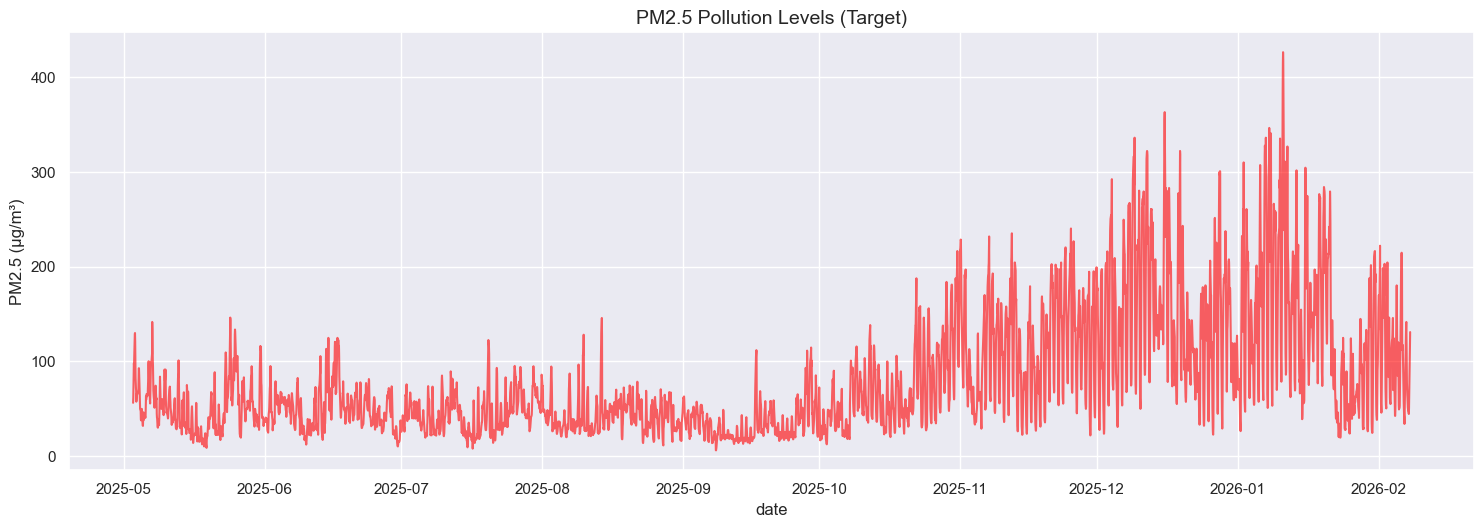

In [22]:
# Setting the visual style
sns.set(style="darkgrid")
plt.figure(figsize=(15, 10))

# Plot 1: Pollution (PM2.5) over time
# Goal: To see if there are spikes (Smog days)
plt.subplot(2, 1, 1)
sns.lineplot(data=df, x=df.index, y='pm25', color='red', alpha=0.6)
plt.title('PM2.5 Pollution Levels (Target)', fontsize=14)
plt.ylabel('PM2.5 (µg/m³)')

plt.tight_layout()
plt.show()

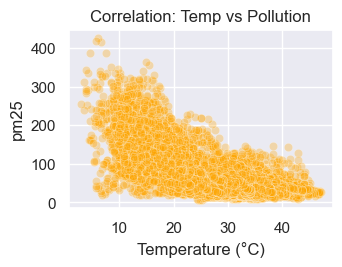

In [23]:
# Plot 2: Temperature vs PM2.5 (Scatter)
# Goal: To see if pollution gets worse when it's cold
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='temp', y='pm25', alpha=0.3, color='orange')
plt.title('Correlation: Temp vs Pollution')
plt.xlabel('Temperature (°C)')

plt.tight_layout()
plt.show()

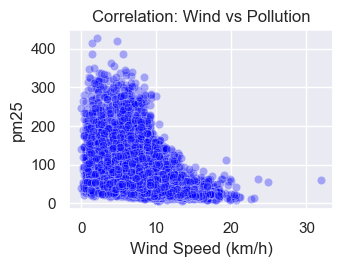

In [24]:
# Plot 3: Wind vs PM2.5
# Goal: Does wind blow the smog away?
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='wind_speed', y='pm25', alpha=0.3, color='blue')
plt.title('Correlation: Wind vs Pollution')
plt.xlabel('Wind Speed (km/h)')

plt.tight_layout()
plt.show()

In [25]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [26]:
# Lag Features (The most powerful predictors)
# "To predict 10 AM, look at 9 AM (Lag 1) and 10 AM yesterday (Lag 24)"
# Hourly
df['pm25_lag_1'] = df['pm25'].shift(1)
df['pm25_lag_6'] = df['pm25'].shift(6)
df['pm25_lag_24'] = df['pm25'].shift(24)

In [27]:
# Rolling Trends (Smoothing out the noise)
# "What was the average pollution over the last week?"
df['pm25_rolling_mean_24h'] = df['pm25'].rolling(window=24).mean()
df['pm25_rolling_std_24h'] = df['pm25'].rolling(window=24).std()

In [28]:
# Cyclical Time Features (Teaching the model that 23:00 is close to 00:00)
# We map hours to a circle (Sin/Cos)
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)

In [29]:
# Interaction Terms (Physics)
# "High Humidity + Low Temp = Smog Trap"
df['humid_temp_interaction'] = df['humidity'] * df['temp']

In [30]:
df.isnull().sum()

temp                       0
humidity                   0
wind_speed                 0
rain                       0
pm10                       0
pm25                       0
pm25_lag_1                 1
pm25_lag_6                 6
pm25_lag_24               24
pm25_rolling_mean_24h     23
pm25_rolling_std_24h      23
hour_sin                   0
hour_cos                   0
humid_temp_interaction     0
dtype: int64

In [31]:
df = df.dropna()

PREPROCESSING

In [32]:
features = ['pm25_lag_1', 'pm25_lag_6', 'pm25_lag_24', 'pm25_rolling_mean_24h',
            'temp', 'humidity', 'wind_speed', 'rain', 'hour_sin', 'hour_cos', 'humid_temp_interaction']
target = 'pm25'

In [33]:
# Using MinMaxScaler (0 to 1) because LSTM/CNN weights converge faster with small numbers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [34]:
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

In [35]:
# CRITICAL: Do NOT shuffle.
# Split: 80% Train, 20% Test
split_idx = int(len(X_scaled) * 0.8)

In [36]:
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

In [37]:
print(f"   Training Shape: {X_train.shape} (Past)")
print(f"   Testing Shape:  {X_test.shape} (Future)")
print(f"   Features Used:  {len(features)}")

   Training Shape: (5376, 11) (Past)
   Testing Shape:  (1344, 11) (Future)
   Features Used:  11


Models Training

In [38]:
models = {
    "1. Linear Regression": LinearRegression(),
    "2. Ridge Regression": Ridge(alpha=1.0),
    "3. SVR (Support Vector)": SVR(kernel='rbf'),
    "4. Random Forest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "5. XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, n_jobs=-1, random_state=42),
    "6. LightGBM": LGBMRegressor(n_estimators=300, learning_rate=0.05, n_jobs=-1, random_state=42, verbose=-1),
    "7. CatBoost": CatBoostRegressor(n_estimators=300, learning_rate=0.05, verbose=0, random_state=42)
}

In [39]:
# Dictionary to store results
results = {}

In [40]:
print("Starting Training Loop for 7 ML Models...")
print("-" * 60)
print(f"{'Model Name':<25} | {'RMSE':<10} | {'R² Score':<10}")
print("-" * 60)

for name, model in models.items():
    # A. Train
    model.fit(X_train, y_train.ravel())

    # B. Predict
    preds_scaled = model.predict(X_test)

    # C. Inverse Transform (Convert 0.5 back to 150 µg/m³)
    # We must reshape preds to (n, 1) for the scaler
    preds_real = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1))
    y_test_real = scaler_y.inverse_transform(y_test)

    # D. Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
    r2 = r2_score(y_test_real, preds_real)

    # Store
    results[name] = {"RMSE": rmse, "R2": r2, "Predictions": preds_real}

    print(f"{name:<25} | {rmse:.2f}       | {r2:.4f}")

print("-" * 60)

Starting Training Loop for 7 ML Models...
------------------------------------------------------------
Model Name                | RMSE       | R² Score  
------------------------------------------------------------
1. Linear Regression      | 20.20       | 0.9269
2. Ridge Regression       | 20.11       | 0.9276
3. SVR (Support Vector)   | 35.71       | 0.7717
4. Random Forest          | 18.52       | 0.9386
5. XGBoost                | 19.63       | 0.9310


C:\Users\Jaweriya\anaconda3\envs\pearls_aqi\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


6. LightGBM               | 18.44       | 0.9392
7. CatBoost               | 18.57       | 0.9383
------------------------------------------------------------


In [41]:
# RESHAPE FOR DEEP LEARNING
# treat each row as 1 "timestep" with 11 features
X_train_dl = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_dl = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(f"Deep Learning Data Shape: {X_train_dl.shape}")

Deep Learning Data Shape: (5376, 1, 11)


In [42]:
# Helper function to build & train
def train_dl_model(model_name, model_obj, epochs=20):
    print(f"\n Training {model_name}...")
    model_obj.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train
    history = model_obj.fit(X_train_dl,
                            y_train,
                            epochs=epochs,
                            batch_size=32,
                            validation_data=(X_test_dl, y_test),
                            verbose=0)

    # Predict
    preds_scaled = model_obj.predict(X_test_dl)
    preds_real = scaler_y.inverse_transform(preds_scaled)
    y_test_real = scaler_y.inverse_transform(y_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
    r2 = r2_score(y_test_real, preds_real)

    print(f" {model_name} -> RMSE: {rmse:.2f} | R²: {r2:.4f}")
    return {"RMSE": rmse, "R2": r2, "Predictions": preds_real}

In [43]:
# --- MODEL 8: LSTM ---
model_lstm = Sequential([
    Input(shape=(1, X_train.shape[1])),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(1)
])
results["8. LSTM"] = train_dl_model("LSTM", model_lstm)


 Training LSTM...
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 LSTM -> RMSE: 18.97 | R²: 0.9356


In [44]:
# --- MODEL 9: 1D-CNN ---
model_cnn = Sequential([
    Input(shape=(1, X_train.shape[1])),
    Conv1D(filters=64, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
results["9. 1D-CNN"] = train_dl_model("1D-CNN", model_cnn)


 Training 1D-CNN...
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 1D-CNN -> RMSE: 17.84 | R²: 0.9430


In [45]:
def classify_aqi(pm25_value):
    if pm25_value <= 30: return "Good"
    elif pm25_value <= 60: return "Satisfactory"
    elif pm25_value <= 90: return "Moderate"
    elif pm25_value <= 120: return "Poor"
    elif pm25_value <= 250: return "Very Poor"
    else: return "Severe"

In [46]:
# We use the BEST model's predictions (LSTM)
best_preds = results["8. LSTM"]["Predictions"]
y_test_real = scaler_y.inverse_transform(y_test) # Make sure we use real unscaled numbers

y_true_classes = [classify_aqi(val) for val in y_test_real]
y_pred_classes = [classify_aqi(val) for val in best_preds]


In [47]:
# 3. Generate Report
labels = ["Good", "Satisfactory", "Moderate", "Poor", "Very Poor", "Severe"]

print("📊 Classification Report (Safety Check):")
print(classification_report(y_true_classes, y_pred_classes, labels=labels))

📊 Classification Report (Safety Check):
              precision    recall  f1-score   support

        Good       1.00      0.12      0.22        41
Satisfactory       0.71      0.60      0.65       168
    Moderate       0.65      0.64      0.65       238
        Poor       0.58      0.59      0.59       211
   Very Poor       0.86      0.91      0.89       564
      Severe       0.76      0.89      0.82       122

    accuracy                           0.75      1344
   macro avg       0.76      0.63      0.63      1344
weighted avg       0.75      0.75      0.74      1344



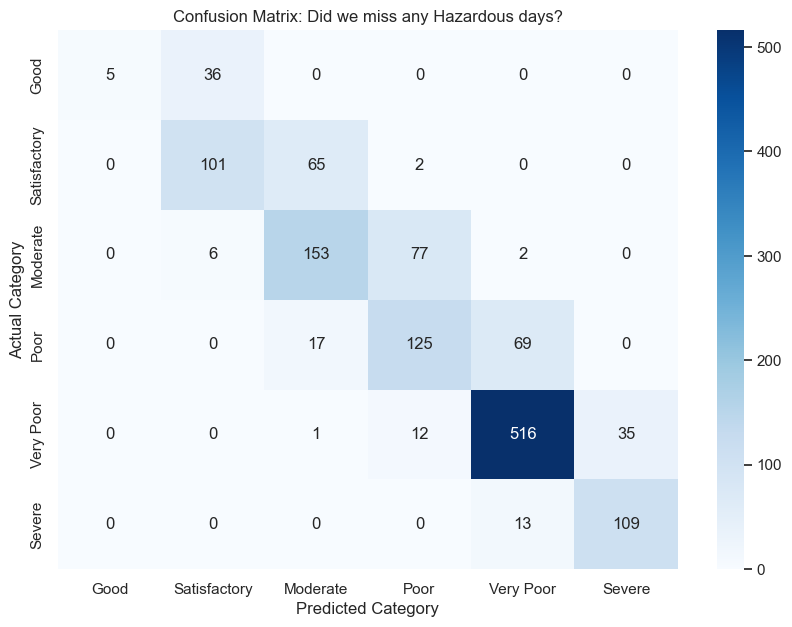

In [48]:
# 4. Confusion Matrix (Visualizing Mistakes)
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix: Did we miss any Hazardous days?')
plt.show()